In [1]:
import pandas as pd
import sys
sys.path.append("/home/calvin/code/cmpnn_revised")
from pathlib import Path

In [2]:
from cmpnn.featurizer.molecule_dataset import MoleculeDataset
from cmpnn.featurizer.atom_bond import AtomFeaturizer, BondFeaturizer
from cmpnn.models.lightning import CMPNNLightningModuleTimed, CMPNNLightningModule
from cmpnn.optimizer.noam import NoamLikeOptimizer
from cmpnn.featurizer.utils import featurize_molecule
from cmpnn.data.collate import mol_collate_fn
from torch.utils.data import DataLoader
from cmpnn.split.crossvalidator import CrossValidator
import torch
from torch.utils.data import random_split
from cmpnn.split.scaffold import ScaffoldSplitter
import logging
from cmpnn.split.utils import log_scaffold_stats, plot_split_distributions
import pytorch_lightning as pl

In [3]:
cmpnn_dir = Path.cwd().parent
csv_file = cmpnn_dir/"cmpnn"/ "mol_data" / "freesolv.csv"

In [4]:
dataset = MoleculeDataset(
    csv_file=csv_file,
    atom_featurizer=AtomFeaturizer(v2=False),
    bond_featurizer=BondFeaturizer(),
    smiles_col="smiles",
    target_cols=["freesolv"],
    use_cache=False,
    atom_messages=False
)

Using all atomic numbers from 1 to 100
Processing data from /home/calvin/code/cmpnn_revised/cmpnn/mol_data/freesolv.csv


# Scaffold

In [5]:
# We instantiate the scaffold splitter
scaff_splitter = ScaffoldSplitter(seed=42)

In [6]:
train_idx, val_idx, test_idx = scaff_splitter.split(
    dataset,
    train_frac=0.8,
    val_frac=0.1,
    test_frac=0.1,
    return_indices=True,
)

In [7]:
logging.basicConfig(level=logging.INFO)

log = log_scaffold_stats(
    data=dataset,
    index_sets=[set(train_idx), set(val_idx), set(test_idx)],
    num_scaffolds=3,
    num_labels=1,
    logger=logging.getLogger("scaffold")
)

INFO:scaffold:Label mean/std/count per split (max 3 splits, 1 labels):
INFO:scaffold:Split 0: mean=[-3.26885], std=[3.280351], count=[513]
INFO:scaffold:Split 1: mean=[-5.600469], std=[5.2969794], count=[64]
INFO:scaffold:Split 2: mean=[-6.2489233], std=[4.6945214], count=[65]


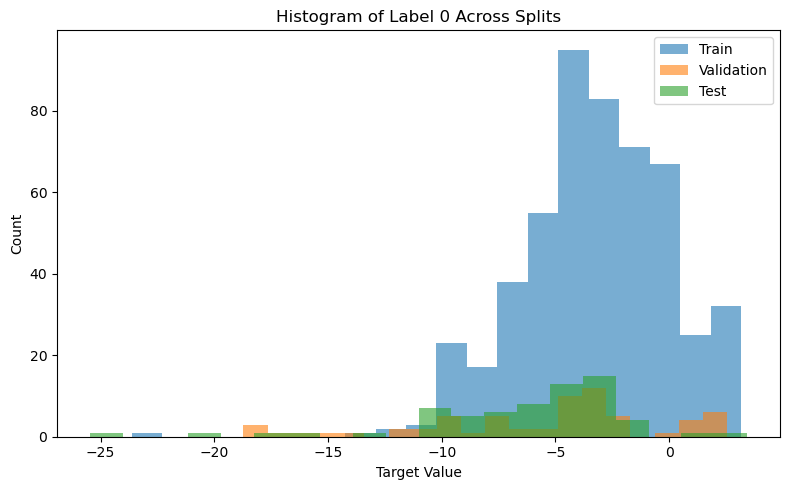

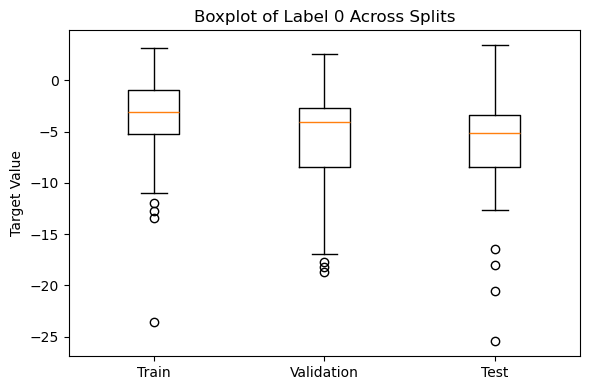

In [8]:
plot_split_distributions(
    dataset=dataset,
    index_sets=[set(train_idx),set(val_idx), set(test_idx)],
    label_index=0
)

# Dataloader

In [9]:
train_dataset = dataset[train_idx]
val_dataset = dataset[val_idx]
test_dataset = dataset[test_idx]

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    collate_fn=mol_collate_fn,
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    collate_fn=mol_collate_fn,
    shuffle=False,
    num_workers=4
)
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    collate_fn=mol_collate_fn,
    shuffle=False,
    num_workers=4
)

# Model w/ Dyanamic Depth (dynamic_depth)

In [10]:
model = CMPNNLightningModule(
    atom_fdim=133,
    bond_fdim=147,
    atom_messages=False,
    global_fdim=0,
    hidden_dim=1024,
    booster="sum",
    comm_mode="add",
    optimizer_class=NoamLikeOptimizer,
    optimizer_params={
        'init_lr': 1e-4,
        'max_lr': 1e-3,
        'final_lr': 1e-5,
        'warmup_steps': 1000,
        'total_steps': 10000,
    },
    dynamic_depth="truncnorm",
    plot_lr=True,
    use_atom_residual=True,
    use_bond_residual=False, # Freesolv is a solvation dataset, so largely atom-level feature dominated, especially for H bond donors/acceptors, polar groups etc.
)


# Pytorch Lightning Training

In [11]:
trainer = pl.Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=1,
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            monitor="val_loss",
            mode="min",
            save_top_k=1,
            filename="{epoch:02d}-{val_loss:.2f}",
        ),
        pl.callbacks.EarlyStopping(monitor="val_loss", patience=10),
    ],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


You are using a CUDA device ('AMD Radeon RX 6600') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | model           | CMPNNEncoder   | 23.4 M | train
1 | atom_projection | MLP            | 2.2 M  | train
2 | aggregator      | MeanAggregator | 0      | train
3 | bn              | Identity       | 0      | train
4 | ffn             | MLP            | 2.1 M  | train
5 | metrics         | ModuleDict     | 0      | train
-----------------------------------------------------------
27.7 M    Trainable params
0         Non-trainable params
27.7 M    Total params
110.817   Total est

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:310.)
  return F.linear(input, self.weight, self.bias)
/home/calvin/miniforge3/envs/dmpnn_rocm/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (17) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


training_logs length = 1700
[DyMPN] Saved LR schedule to /home/calvin/code/cmpnn_revised/scripts/lightning_logs/version_9/lr_schedule.png
[DyMPN] Saved training logs to /home/calvin/code/cmpnn_revised/scripts/lightning_logs/version_9/depth_loss_log.json
[DyMPN] Saved depth-loss plot to /home/calvin/code/cmpnn_revised/scripts/lightning_logs/version_9/depth_loss_plot.png


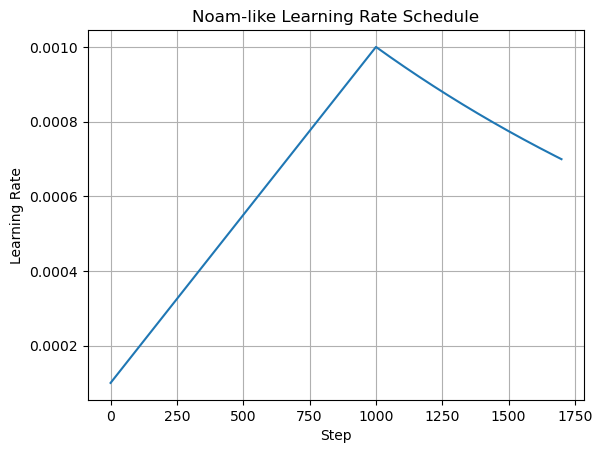

In [12]:
trainer.fit(
    model,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

In [13]:
model.training_logs

[{'depth': 4, 'loss': 18.012731552124023},
 {'depth': 3, 'loss': 19.582754135131836},
 {'depth': 3, 'loss': 19.51862144470215},
 {'depth': 3, 'loss': 18.81467056274414},
 {'depth': 3, 'loss': 16.128765106201172},
 {'depth': 3, 'loss': 28.422786712646484},
 {'depth': 3, 'loss': 30.19605255126953},
 {'depth': 4, 'loss': 12.977799415588379},
 {'depth': 2, 'loss': 21.050800323486328},
 {'depth': 3, 'loss': 15.013082504272461},
 {'depth': 1, 'loss': 24.88282012939453},
 {'depth': 1, 'loss': 26.37091064453125},
 {'depth': 5, 'loss': 10.324670791625977},
 {'depth': 2, 'loss': 13.14115047454834},
 {'depth': 2, 'loss': 21.604812622070312},
 {'depth': 3, 'loss': 11.14814281463623},
 {'depth': 3, 'loss': 20.23506736755371},
 {'depth': 2, 'loss': 31.410722732543945},
 {'depth': 3, 'loss': 8.370072364807129},
 {'depth': 3, 'loss': 17.702796936035156},
 {'depth': 3, 'loss': 13.786873817443848},
 {'depth': 2, 'loss': 15.941640853881836},
 {'depth': 4, 'loss': 16.636627197265625},
 {'depth': 4, 'loss'

In [15]:
trainer.test(
    model,
    dataloaders=test_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            MAE            │     3.822110652923584     │
│            R2             │     0.082919180393219     │
│           RMSE            │     4.495677471160889     │
└───────────────────────────┴───────────────────────────┘

[{'RMSE': 4.495677471160889,
  'MAE': 3.822110652923584,
  'R2': 0.082919180393219}]